In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Load microbiome data and metadata

In [2]:
# read sample meta data and eliminate samples without transplant day
df_sample = pd.read_csv('tblASVsamples.csv', index_col=0)
df_sample = df_sample[df_sample.DayRelativeToNearestHCT.notnull()]

# read count data
df_count = pd.read_csv('tblcounts_asv_melt.csv')
df_count = pd.pivot_table(df_count, index='SampleID', columns='ASV', values='Count', aggfunc=np.sum).fillna(0)
sample_ids_w_suff_reads = list(df_count.sum(axis=1)[df_count.sum(axis=1)>=1000].index)
df_count = df_count.loc[set(df_sample.index).intersection(set(sample_ids_w_suff_reads))]
df_relab_asv =  df_count.div(df_count.sum(axis=1), axis=0)

# find commmon samples
common_samples = set(df_sample.index).intersection(set(df_relab_asv.index))
df_sample = df_sample.loc[common_samples]
df_relab_asv = df_relab_asv.loc[common_samples]

# get oral bacterial fraction
df_blast_100 = pd.read_csv("blast_HMPv35oral/blast_HMPv35oral_p100.txt", sep="\t", comment="#", header=None)
df_blast_100.columns = ['query_accver', 'subject_accver', 'perc_identity', 'alignment_length', 'mismatches', 'gap_opens', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']#
df_oral_total = df_relab_asv[set(df_blast_100.query_accver).intersection(df_relab_asv.columns)].sum(axis=1).to_frame()
df_oral_total.columns = ['OralFrac_HMPv35oral']
df_oral_total = df_oral_total.reset_index('SampleID').sort_values(['OralFrac_HMPv35oral','SampleID']).set_index('SampleID')
df_oral_total['log10_OralFrac_HMPv35oral'] = np.log10(df_oral_total['OralFrac_HMPv35oral'])

# read qPCR data
df_qpcr=pd.read_csv('tblqpcr.csv', index_col=0)
df_qpcr = df_qpcr[df_qpcr.qPCR16S>0]
df_qpcr['log10_qPCR16S'] = np.log10(df_qpcr.qPCR16S)

# joint sample, oral fraction and qpcr
df = pd.merge(df_oral_total, df_qpcr, left_index=True, right_index=True, how='inner')
df = pd.merge(df, df_sample, left_index=True, right_index=True, how='inner')
df = df[df.OralFrac_HMPv35oral>0]

# Fig. 4c

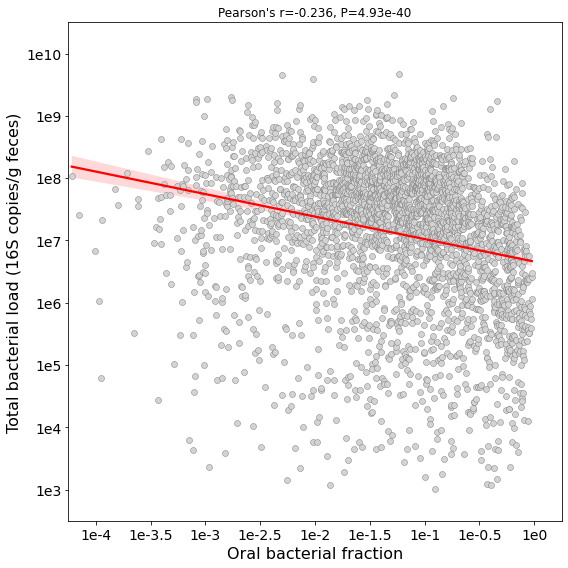

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))

df = df[df.qPCR16S>=1e3]
_ = sns.regplot(data=df, x='log10_OralFrac_HMPv35oral', y='log10_qPCR16S', ax=ax, scatter_kws={"color": "black"}, line_kws={"color": "red"}, scatter=False)
_ = sns.scatterplot(data=df, x='log10_OralFrac_HMPv35oral', y='log10_qPCR16S', ax=ax, color='lightgray', edgecolor='gray')
_ = ax.set_ylabel('Total bacterial load (16S copies/g feces)', fontsize=16)
_ = ax.set_xlabel('Oral bacterial fraction', fontsize=16)
slope, intercept, r_value, p_value, std_err = stats.linregress(df.log10_OralFrac_HMPv35oral, df.log10_qPCR16S)
_ = ax.set_title('Pearson\'s r=%2.3f, P=%2.2e'%(r_value, p_value))
_ = ax.set_xlim([-4.25, 0.25])
_ = ax.set_ylim([2.5,10.5])
_ = ax.set_xticks([-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0])
_ = ax.set_xticklabels(['1e-4','1e-3.5','1e-3','1e-2.5','1e-2','1e-1.5','1e-1','1e-0.5','1e0'], fontsize=14)
_ = ax.set_yticks([3,4,5,6,7,8,9,10])
_ = ax.set_yticklabels(['1e3','1e4','1e5','1e6','1e7','1e8','1e9','1e10'], fontsize=14)

plt.tight_layout()